In [1]:
import json
import pandas as pd

In [2]:
file_path = "../data/train.json"

with open(file_path, "r") as file:
    data = json.load(file)

In [3]:
df = pd.DataFrame(data)

In [4]:
df

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."
...,...,...,...,...,...
6802,22678,EXAMPLE – JOURNEY MAP\n\nTHE CHALLENGE My w...,"[EXAMPLE, –, JOURNEY, MAP, \n\n, THE, CHALLENG...","[True, True, True, False, False, True, True, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6803,22679,Why Mind Mapping?\n\nMind maps are graphical r...,"[Why, Mind, Mapping, ?, \n\n, Mind, maps, are,...","[True, True, False, False, False, True, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6804,22681,"Challenge\n\nSo, a few months back, I had chos...","[Challenge, \n\n, So, ,, a, few, months, back,...","[False, False, False, True, True, True, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6805,22684,Brainstorming\n\nChallenge & Selection\n\nBrai...,"[Brainstorming, \n\n, Challenge, &, Selection,...","[False, False, True, True, False, False, True,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


### Data

In [5]:
import numpy as np
labels = np.concatenate(df['labels'])

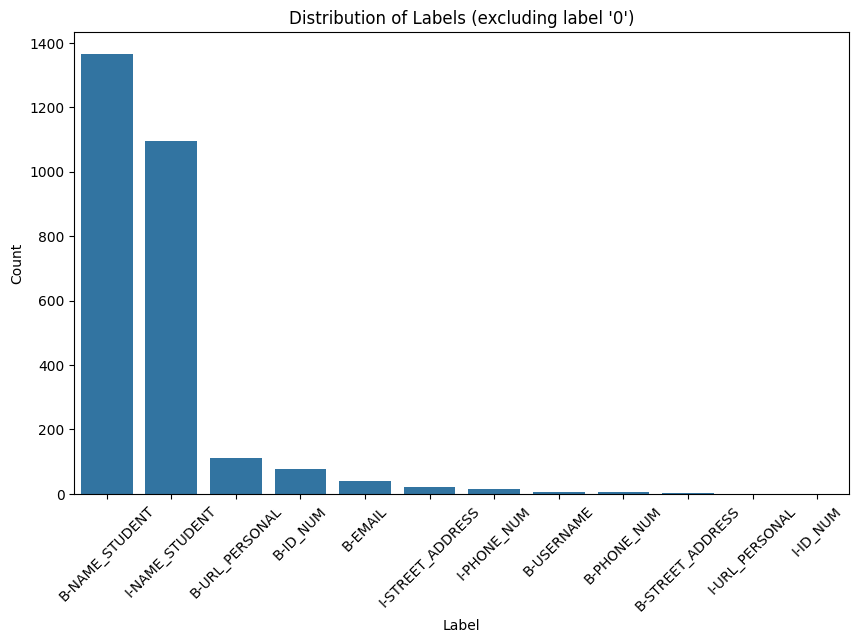

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Exclude label "0" from the counts
label_counts = pd.Series(labels).value_counts().drop("O")

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Labels (excluding label '0')")

# Rotate x-labels
plt.xticks(rotation=45)

plt.show()


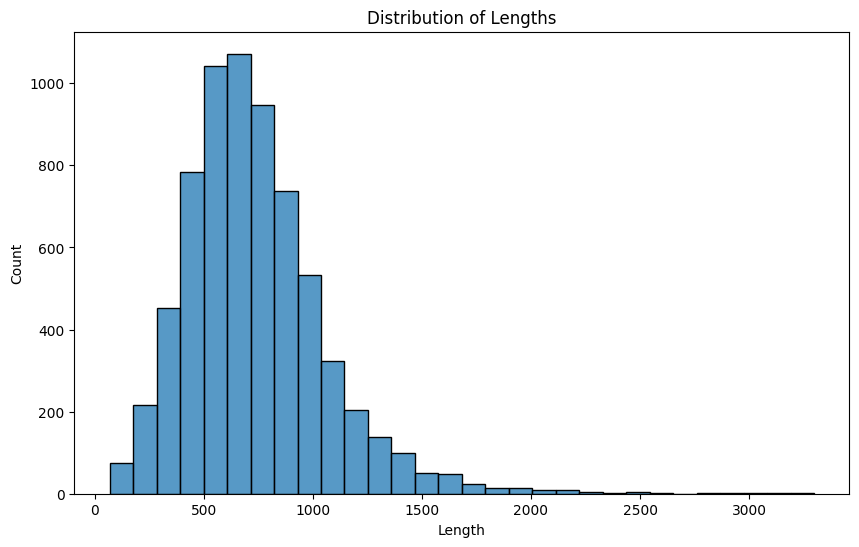

In [7]:
# Plot lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['tokens'].apply(len), bins=30)
plt.xlabel("Length")
plt.ylabel("Count")
plt.title("Distribution of Lengths")
plt.show()

In [8]:
# Positions of PII
pos = [[i for i, ele in enumerate(entry) if ele != 'O'] for entry in df['labels']]

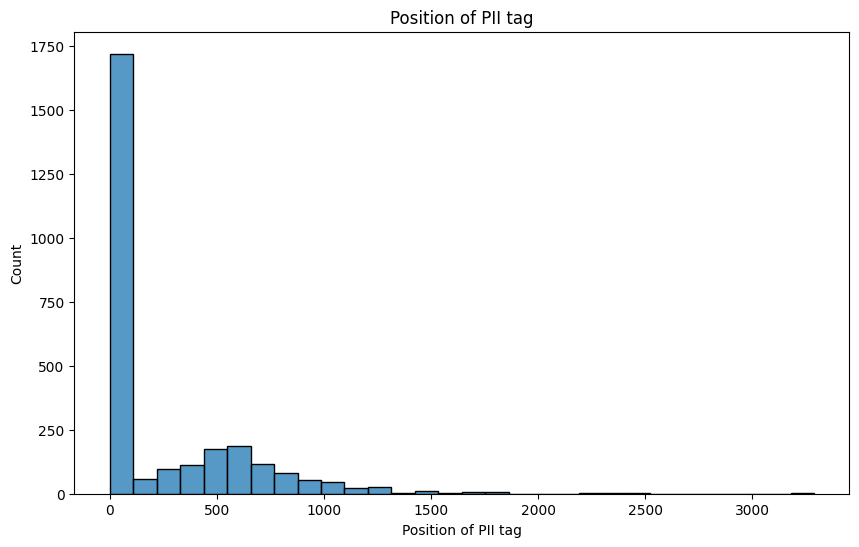

In [9]:
# Plot lengths
plt.figure(figsize=(10, 6))
sns.histplot(np.concatenate(pos), bins=30)
plt.xlabel("Position of PII tag")
plt.ylabel("Count")
plt.title("Position of PII tag")
plt.show()

## Gender Analysis?

In [19]:
df['labels'].apply(lambda x: [i for i, word in enumerate(x) if (word == 'B-NAME_STUDENT') or (word == 'I-NAME_STUDENT')])

0       [9, 10, 482, 483, 741, 742]
1                  [0, 1, 464, 465]
2                            [4, 5]
3                            [5, 6]
4                          [12, 13]
                   ...             
6802                             []
6803                             []
6804                             []
6805                             []
6806                             []
Name: labels, Length: 6807, dtype: object

# Creating dataset

In [11]:
import torch

class PIIDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [132]:
df['labels'].apply(lambda x: x[:512])

# Zero-pad the labels to 512
df['labels'].apply(lambda x: x[:512] + ['O'] * (512 - len(x)))

labels
512    6807
Name: count, dtype: int64

In [12]:
import pandas as pd
from transformers import BertForTokenClassification, BertTokenizerFast, TrainingArguments, Trainer
import torch
from sklearn.model_selection import train_test_split

def load_datasets(df, tokenizer):

    # Split data into train and test sets
    
    # Zero-pad the labels and truncate to 512
    pad_trunc_labels = df['labels'].apply(lambda x: x[:512] + ['O'] * (512 - len(x)))
    train_texts, test_texts, train_labels, test_labels = train_test_split(df['tokens'], pad_trunc_labels, test_size=0.2)

    # Tokenize and encode the data
    train_encodings = tokenizer(train_texts.to_list(), is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)
    test_encodings = tokenizer(test_texts.to_list(), is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)

    # Labels
    labels = np.concatenate(df['labels'])

    # Convert train and test data to datasets
    label2id = {label: i for i, label in enumerate(np.flip(np.unique(labels)))}
    train_labels_numeric = [[label2id[label] for label in sent] for sent in train_labels]
    test_labels_numeric = [[label2id[label] for label in sent] for sent in test_labels]

    # Dataset
    data = {}
    data['train'] = PIIDataset(train_encodings, train_labels_numeric)
    data['test'] = PIIDataset(test_encodings, test_labels_numeric)
    data['label2id'] = label2id

    return data

/opt/anaconda3/envs/adv_ba/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
# Initialize BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Load datasets
data = load_datasets(df[:500], tokenizer)

In [14]:
# Initialize model
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(data['label2id']))

# Training arguments
training_args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='./logs',
    logging_steps=500,
    save_steps=1000,
    eval_steps=1000,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    evaluation_strategy='steps',
    num_train_epochs=10,
    output_dir='./results',
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data['train'],
    eval_dataset=data['test'],
    tokenizer=tokenizer,
    data_collator=None,
    compute_metrics=None,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# Train the model
trainer.train()

# Evaluate the model
trainer.evaluate()

# Save the model
trainer.save_model('./results')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  0%|          | 0/500 [00:00<?, ?it/s]

RuntimeError: MPS backend out of memory (MPS allocated: 5.09 GB, other allocations: 1.80 GB, max allowed: 6.80 GB). Tried to allocate 12.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).